<a href="https://colab.research.google.com/github/Dharani-Gurumoorthy/Lung_Cancer_Prediction/blob/main/lung_cancer_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install opendatasets
!pip pandas

ERROR: unknown command "pandas"


In [4]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images")

Skipping, found downloaded files in "./chest-ctscan-images" (use force=True to force download)


In [5]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [6]:
# File Directory for both the train and test
train_path = "/content/chest-ctscan-images/Data/train"
val_path = "/content/chest-ctscan-images/Data/valid"
test_path = "/content/chest-ctscan-images/Data/test"

In [7]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Counting the Number of Files in the Folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",val_set,"\n\n",test_set)

{'normal': 148, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195} 

 {'normal': 13, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23} 

 {'squamous.cell.carcinoma': 90, 'normal': 54, 'adenocarcinoma': 120, 'large.cell.carcinoma': 51}


In [8]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.7.1


In [9]:
!pip install matplotlib --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 99.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.0
    Uninstalling pyparsing-3.1.0:
      Successfully uninstalled pyparsing-3.1.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


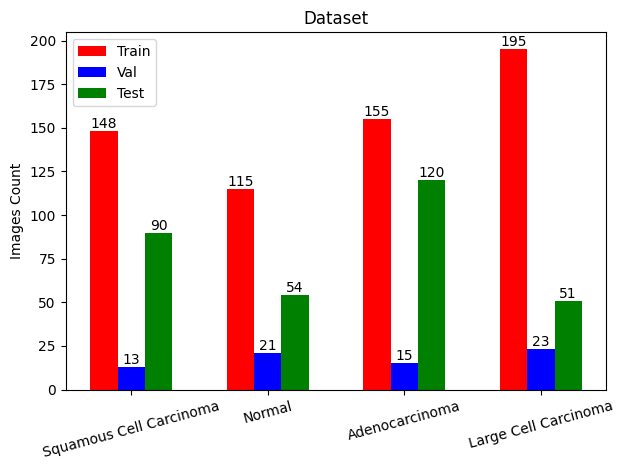

In [10]:
labels = ['Squamous Cell Carcinoma', 'Normal', 'Adenocarcinoma', 'Large Cell Carcinoma']
train_list = list(train_set.values())
val_list = list(val_set.values())
test_list = list(test_set.values())

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_list, width, label='Train',color = 'red')
rects2 = ax.bar(x, val_list, width, label='Val', color = 'blue')
rects3 = ax.bar(x + width, test_list, width, label='Test', color = 'green')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Images Count')
ax.set_title('Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation=15)
ax.legend()

ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

fig.tight_layout()

plt.show()

<h2>
Importing Keras for Image Classification

In [11]:
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout

In [12]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)

train_data = train_datagen.flow_from_directory(train_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.


In [13]:
train_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [14]:
val_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_data = val_datagen.flow_from_directory(val_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 72 images belonging to 4 classes.


In [15]:
val_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [16]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_data = test_datagen.flow_from_directory(test_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 315 images belonging to 4 classes.


In [17]:
test_data.class_indices

{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

<h2>Incep

In [18]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(input_shape = (350, 350, 3),
                         include_top = False,
                         weights = 'imagenet')


for layer in base_model.layers:
    layer.trainable = False


x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 4 node for classification output
x = layers.Dense(4, activation='sigmoid')(x)

model_incep = tf.keras.models.Model(base_model.input, x)

model_incep.compile(optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=0.0001),
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

87910968/87910968 [==============================] - 5s 0us/step


In [19]:
mc1 = ModelCheckpoint(
    filepath="./ct_incep_best_model.hdf5",
    monitor= 'val_accuracy',
    verbose= 1,
    save_best_only= True,
    mode = 'auto'
    );

call_back = [mc1];

In [20]:
# Fitting the Model
incep = model_incep.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size,
    epochs = 32,
    validation_data = val_data,
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back
    )

Epoch 1/32
122/122 [==============================] - ETA: 0s - loss: 6.6455 - accuracy: 0.4178
Epoch 1: val_accuracy improved from -inf to 0.38571, saving model to ./ct_incep_best_model.hdf5
122/122 [==============================] - 57s 324ms/step - loss: 6.6455 - accuracy: 0.4178 - val_loss: 2.7790 - val_accuracy: 0.3857
Epoch 2/32
122/122 [==============================] - ETA: 0s - loss: 1.9310 - accuracy: 0.5247
Epoch 2: val_accuracy improved from 0.38571 to 0.58571, saving model to ./ct_incep_best_model.hdf5
122/122 [==============================] - 31s 256ms/step - loss: 1.9310 - accuracy: 0.5247 - val_loss: 1.0854 - val_accuracy: 0.5857
Epoch 3/32
122/122 [==============================] - ETA: 0s - loss: 1.4108 - accuracy: 0.5806
Epoch 3: val_accuracy did not improve from 0.58571
122/122 [==============================] - 23s 190ms/step - loss: 1.4108 - accuracy: 0.5806 - val_loss: 1.4079 - val_accuracy: 0.5143
Epoch 4/32
122/122 [==============================] - ETA: 0s - 

In [21]:
# Loading the Best Fit Model
model_incep = load_model("./ct_incep_best_model.hdf5")

Resnet 50 Model

In [22]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(350, 350,3),
                      include_top=False, weights="imagenet",
                      pooling='max')

94765736/94765736 [==============================] - 5s 0us/step


In [23]:
for layer in base_model.layers:
    layer.trainable = False

In [24]:
model_resnet = Sequential()
model_resnet.add(base_model)
model_resnet.add(Dense(4, activation='sigmoid'))

In [25]:
model_resnet.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001),
                     loss = 'categorical_crossentropy',
                     metrics = ['accuracy'])

In [26]:
# Adding Model check point Callback

mc = ModelCheckpoint(
    filepath="./ct_resnet_best_model.hdf5",
    monitor= 'val_accuracy',
    verbose= 1,
    save_best_only= True,
    mode = 'auto'
    );

call_back = [mc];

In [27]:
# Fitting the Model
resnet = model_resnet.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size,
    epochs = 32,
    validation_data = val_data,
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back
    )

Epoch 1/32
122/122 [==============================] - ETA: 0s - loss: 1.4674 - accuracy: 0.2911
Epoch 1: val_accuracy improved from -inf to 0.30000, saving model to ./ct_resnet_best_model.hdf5
122/122 [==============================] - 30s 209ms/step - loss: 1.4674 - accuracy: 0.2911 - val_loss: 1.3372 - val_accuracy: 0.3000
Epoch 2/32
122/122 [==============================] - ETA: 0s - loss: 1.3123 - accuracy: 0.3947
Epoch 2: val_accuracy did not improve from 0.30000
122/122 [==============================] - 22s 182ms/step - loss: 1.3123 - accuracy: 0.3947 - val_loss: 1.3819 - val_accuracy: 0.2857
Epoch 3/32
122/122 [==============================] - ETA: 0s - loss: 1.2178 - accuracy: 0.4375
Epoch 3: val_accuracy improved from 0.30000 to 0.34286, saving model to ./ct_resnet_best_model.hdf5
122/122 [==============================] - 23s 188ms/step - loss: 1.2178 - accuracy: 0.4375 - val_loss: 1.1627 - val_accuracy: 0.3429
Epoch 4/32
122/122 [==============================] - ETA: 0s 

In [28]:
# Loading the Best Fit Model
model = load_model("./ct_resnet_best_model.hdf5")

In [29]:
test_score = model_incep.evaluate_generator(generator= test_data)
test_score_resnet = model.evaluate_generator(generator= test_data)

In [30]:
# Checking the Accuracy of the Model Resnet50
accuracy_resnet = model.evaluate_generator(generator= test_data)[1]
print(f"The accuracy of the model is = {accuracy_resnet*100} %")
loss_resnet = test_score[0]
print(f"The loss of the model is = {loss_resnet} %")

The accuracy of the model is = 54.603177309036255 %
The loss of the model is = 0.5177663564682007 %


In [31]:
# Checking the Accuracy of the Incep
accuracy_incep = model_incep.evaluate_generator(generator= test_data)[1]
print(f"The accuracy of the model is = {accuracy_incep*100} %")
loss_incep = test_score[0]
print(f"The loss of the model is = {loss_incep} %")

The accuracy of the model is = 82.53968358039856 %
The loss of the model is = 0.5177663564682007 %


In [32]:
incep.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

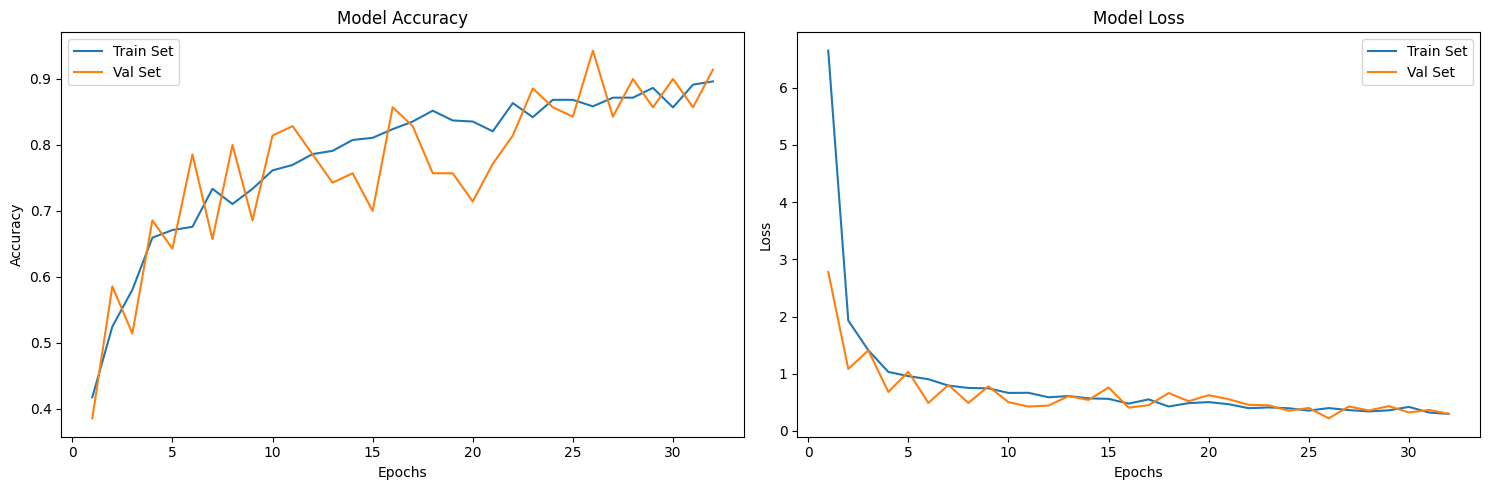

In [33]:
# Plot model performance
acc = incep.history['accuracy']
val_acc = incep.history['val_accuracy']
loss = incep.history['loss']
val_loss = incep.history['val_loss']
epochs_range = range(1, len(incep.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

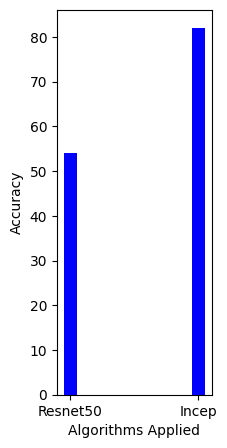

In [34]:
algos = ['Resnet50','Incep']
accuracy = [accuracy_resnet, accuracy_incep]
accuracy = np.floor([i * 100 for i in accuracy])

fig = plt.figure(figsize = (2, 5))
#fig.set_figwidth(4)

# creating the bar plot
plt.bar(algos, accuracy, color ='blue', width = 0.1)

plt.xlabel("Algorithms Applied")
plt.ylabel("Accuracy")
plt.show()

Confusion Matrix

Confusion Matrix
Normalized confusion matrix
Classification Report
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.37      0.78      0.50       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.00      0.00      0.00        51
                                          normal       0.18      0.20      0.19        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.00      0.00      0.00        90

                                        accuracy                           0.33       315
                                       macro avg       0.14      0.24      0.17       315
                                    weighted avg       0.17      0.33      0.22       315



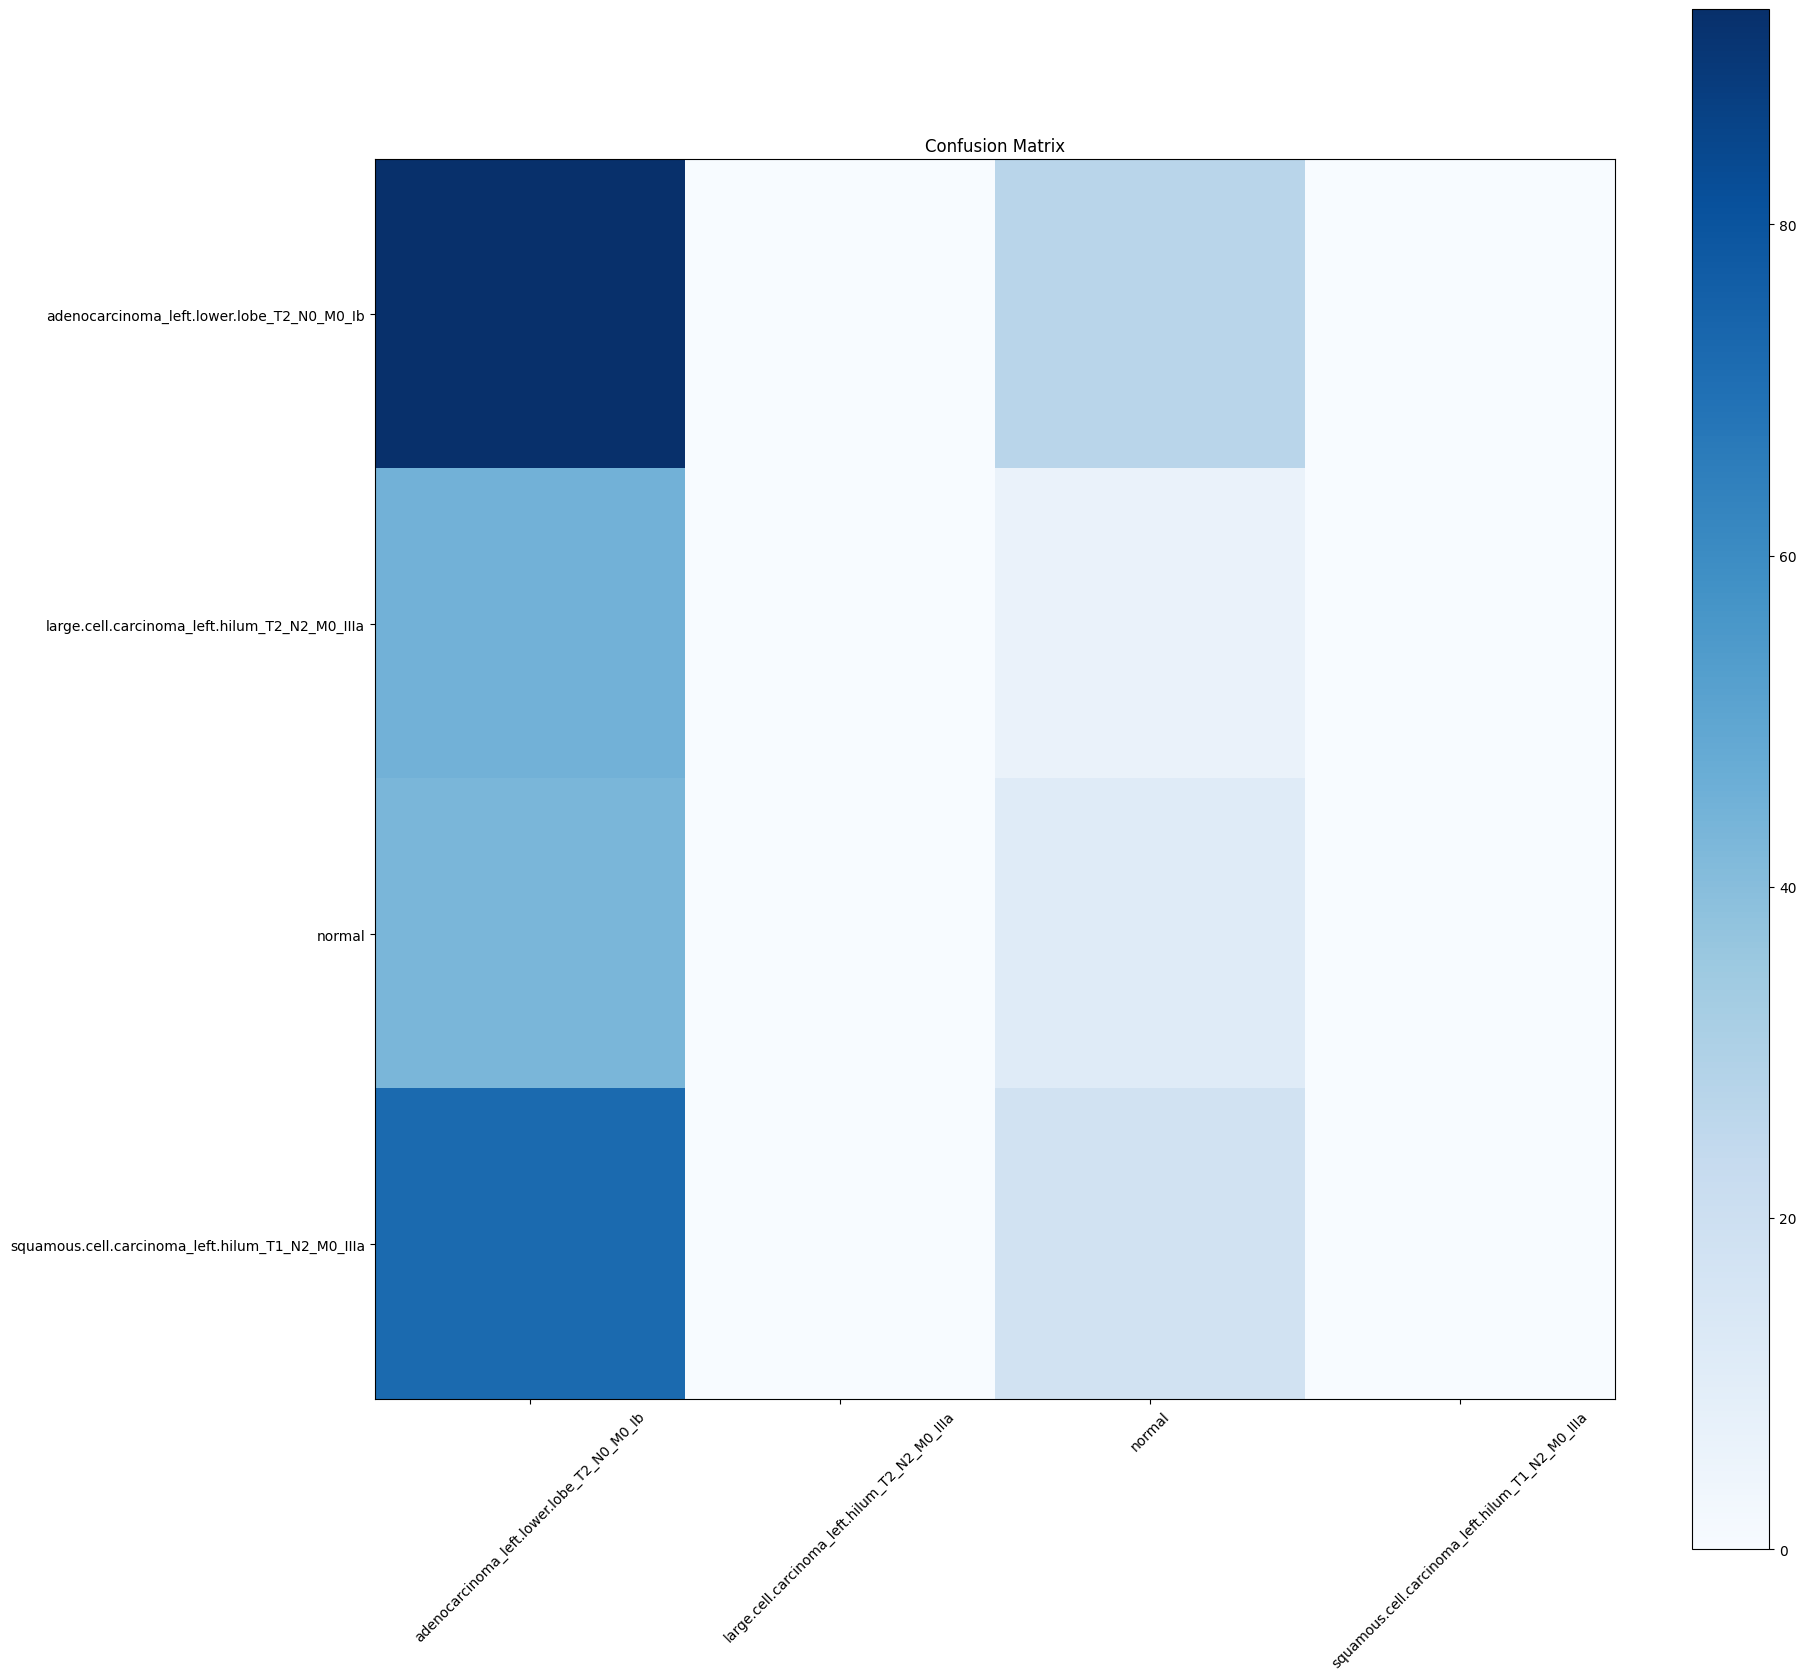

In [35]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            plt.tight_layout()
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools
#shuffle=False
target_names = []
for key in train_data.class_indices:
    target_names.append(key)
# print(target_names)
#Confution Matrix
Y_pred = model.predict_generator(test_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_data.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
#Print Classification Report
print('Classification Report')
print(classification_report(test_data.classes, y_pred, target_names=target_names))

Predictions

In [36]:
def chestScanPrediction(path, _model):
    classes_dir = ["Adenocarcinoma","Large cell carcinoma","Normal","Squamous cell carcinoma"]
    # Loading Image
    img = image.load_img(path, target_size=(350,350))
    # Normalizing Image
    norm_img = image.img_to_array(img)/250
    # Converting Image to Numpy Array
    input_arr_img = np.array([norm_img])
    # Getting Predictions
    pred = np.argmax(_model.predict(input_arr_img))
    # Printing Model Prediction
    print(classes_dir[pred])

In [39]:
path = "/content/chest-ctscan-images/Data/test/normal/10 (2) - Copy.png"
chestScanPrediction(path,model_incep)

1/1 [==============================] - 2s 2s/step
Normal
